- Similar to abstracts_2 but using extended keyword sets.
- Probably too many generic words there, so needs to have 2 keyword matches to get labeled.
- Excluding queries with over 90% overlap

Result:
- Predicts RL a lot for unseen data. 
- Predicts almost no multilabels for unseen data.
- Predictions are almost identical to training labels for training data.

## Setup

In [1]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")
overlap_pairs_path = Path("../../data/processed/queries/overlap_pairs.csv")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = True


#### Create Abstracts dataset (only need to do this once)

In [ ]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
if CREATE_ABSTRACTS_DATASET:
    # Exclude highly overlapping queries based on overlap_pairs.csv

    queries_to_exclude = set()
    overlap_threshold = 0.90

    if overlap_pairs_path.exists():
        overlaps = pd.read_csv(overlap_pairs_path)

        # Ignore self-overlaps
        overlaps = overlaps[overlaps["query_a"] != overlaps["query_b"]].copy()

        # Build size lookup per query
        sizes = {}
        for _, row in overlaps.iterrows():
            sizes[row["query_a"]] = row["size_a"]
            sizes[row["query_b"]] = row["size_b"]

        # Collect pairs where at least one side is highly covered
        pair_info = {}
        for _, row in overlaps.iterrows():
            qa = row["query_a"]
            qb = row["query_b"]
            pct_a = row["overlap_pct_of_a"]
            pct_b = row["overlap_pct_of_b"]

            if pct_a < overlap_threshold and pct_b < overlap_threshold:
                continue

            # Use sorted key so (qa, qb) and (qb, qa) collapse to one pair
            key = tuple(sorted([qa, qb]))
            # Keep the strongest evidence for this pair
            score = max(pct_a, pct_b)
            if key not in pair_info or score > pair_info[key]["score"]:
                pair_info[key] = {
                    "qa": qa,
                    "qb": qb,
                    "pct_a": pct_a,
                    "pct_b": pct_b,
                    "score": score,
                }

        # Decide which query to drop per pair
        for info in pair_info.values():
            qa = info["qa"]
            qb = info["qb"]
            pct_a = info["pct_a"]
            pct_b = info["pct_b"]

            if pct_a >= overlap_threshold and pct_b >= overlap_threshold:
                # Mutual high overlap: drop one of them
                size_qa = sizes.get(qa, 0)
                size_qb = sizes.get(qb, 0)

                if size_qa < size_qb:
                    drop = qa
                elif size_qb < size_qa:
                    drop = qb
                else:
                    # Same size: drop lexicographically later id
                    drop = max(qa, qb)

            elif pct_a >= overlap_threshold:
                # A is highly covered by B -> drop A
                drop = qa

            elif pct_b >= overlap_threshold:
                # B is highly covered by A -> drop B
                drop = qb

            else:
                continue

            queries_to_exclude.add(drop)

        print(f"Excluding {len(queries_to_exclude)} queries based on >= {overlap_threshold:.0%} coverage:")
        for q in sorted(queries_to_exclude):
            print(" -", q)
    else:
        print(f"No overlap file found at: {overlap_pairs_path}. Not excluding any queries.")


Excluding 5 queries based on >= 90% coverage:
 - ml_automation
 - ml_defect_detection
 - ml_manufacturing_optimization
 - ml_process_optimization
 - ml_quality_control


In [6]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        
        # Skip queries marked as highly overlapping
        if query_id in queries_to_exclude:
            print(f"Skipping query due to high overlap: {query_id}")
            continue
        
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


Skipping query due to high overlap: ml_automation
Skipping query due to high overlap: ml_defect_detection
Skipping query due to high overlap: ml_manufacturing_optimization
Skipping query due to high overlap: ml_process_optimization
Skipping query due to high overlap: ml_quality_control

Collected 44071 abstracts from 19 queries
Saved: ../../data/processed/abstracts/abstracts.csv


In [7]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


In [8]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [9]:
# Gather all extended keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised_ext.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised_ext.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement_ext.txt"),
    }


ml_keywords = load_all_keywords()


In [10]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

# Keyword labeling: require at least 2 keyword matches per category
def count_keywords(text, keywords):
    text = (text or "").lower()
    return sum(1 for kw in keywords if contains_keyword(text, kw))

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: 1 if count_keywords(t, ml_keywords[lab]) >= 2 else 0
    )

    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0


In [11]:
# Create a column: "ml_type" that lists all categories with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0,"[supervised, unsupervised]"
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,[unknown]
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",1,0,0,[supervised]
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,1,0,0,[supervised]
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,0,0,0,[unknown]


In [12]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          25000
supervised       15885
reinforcement     2921
unsupervised      2418
Name: count, dtype: int64

In [13]:
# Show some examples with only unsupervised keyword label
mask_only_unsup = (
    (df["is_unsupervised"] == 1) &
    (df["is_supervised"] == 0) &
    (df["is_reinforcement"] == 0)
)

df_only_unsup = df[mask_only_unsup]
print("Total only unsupervised:", len(df_only_unsup), "\n")

df_only_unsup.head()


Total only unsupervised: 995 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
11,ml_anomaly_detection_production,2-s2.0-105012866474,10.1016/j.oceaneng.2025.122365,Scour identification around offshore wind turb...,© 2025 The AuthorsThis paper presents a novel ...,© 2025 The AuthorsThis paper presents a novel ...,0,1,0,[unsupervised]
12,ml_anomaly_detection_production,2-s2.0-105019525303,10.1016/j.jii.2025.100970,Distillation anomaly and fault detection based...,© 2025 The Author(s)Anomaly detection in produ...,Anomaly detection in production processes is e...,0,1,0,[unsupervised]
37,ml_anomaly_detection_production,2-s2.0-105008479968,10.1007/s10489-025-06603-1,Multi-block local outlier factor anomaly detec...,© The Author(s) 2025.Anomaly detection is crit...,2025.Anomaly detection is critical in industri...,0,1,0,[unsupervised]
42,ml_anomaly_detection_production,2-s2.0-105008358010,10.1088/1361-6633/add762,Model-agnostic search for dijet resonances wit...,Creative Commons Attribution license.This pape...,Creative Commons Attribution license.This pape...,0,1,0,[unsupervised]
46,ml_anomaly_detection_production,2-s2.0-105000669270,10.1016/j.apacoust.2025.110687,Enhancing quality inspection of highly variant...,© 2025 Elsevier LtdQuality inspection is an im...,© 2025 Elsevier LtdQuality inspection is an im...,0,1,0,[unsupervised]


In [14]:
# Show some examples with only reinforcement keyword label
mask_only_rl = (
    (df["is_reinforcement"] == 1) &
    (df["is_supervised"] == 0) &
    (df["is_unsupervised"] == 0)
)

df_only_rl = df[mask_only_rl]
print("Total only reinforcement:", len(df_only_rl), "\n")

df_only_rl.head()


Total only reinforcement: 2124 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
76,ml_anomaly_detection_production,2-s2.0-105019060994,10.1109/EEAIS66172.2025.11170654,AI-Driven Automation in Telecom Infrastructure...,"© 2025 IEEE.This paper presents a novel, paten...","© 2025 IEEE.This paper presents a novel, paten...",0,0,1,[reinforcement]
84,ml_anomaly_detection_production,2-s2.0-105017718104,10.2118/226728-MS,Offshore Production Surveillance and Intervent...,"Copyright © 2025, Society of Petroleum Enginee...","Copyright © 2025, Society of Petroleum Enginee...",0,0,1,[reinforcement]
131,ml_anomaly_detection_production,2-s2.0-105006979277,10.2118/225238-MS,Neuron 5 Transforming the Industry Autonomous ...,"Copyright 2025, Society of Petroleum Engineers...","Copyright 2025, Society of Petroleum Engineers...",0,0,1,[reinforcement]
136,ml_anomaly_detection_production,2-s2.0-105004325549,None,2nd International Conference on Cognitive Mobi...,The proceedings contain 34 papers. The special...,The proceedings contain 34 papers. The special...,0,0,1,[reinforcement]
144,ml_anomaly_detection_production,2-s2.0-105001299312,None,2nd European Symposium on Artificial Intellige...,The proceedings contain 29 papers. The special...,The proceedings contain 29 papers. The special...,0,0,1,[reinforcement]


In [15]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,48,297,291,230
ml_disassembly,32,89,217,11
ml_end_of_life,3,15,32,2
ml_inservice_monitoring,60,302,537,59
ml_manufacturing,1015,5291,10524,825
ml_planning_production,228,887,1178,103
ml_plm,11,69,173,6
ml_predictive_maintenance,243,2531,1675,360
ml_process_control,299,929,1991,183


In [16]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.360441
is_unsupervised     0.054866
is_reinforcement    0.066279
dtype: float64

<Axes: xlabel='ml_type'>

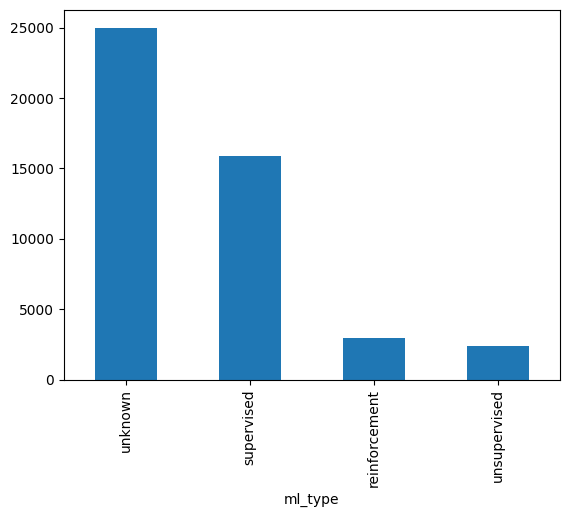

In [17]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [18]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
18461,ml_manufacturing,2-s2.0-84958159965,None,Automatic generation of image-processing progr...,Image-processing systems are applied at many s...,Image-processing systems are applied at many s...,0,0,0,[unknown]
5100,ml_manufacturing,2-s2.0-105013177600,10.1007/978-3-031-94439-0_12,Food Safety 4.0: The Future of Food Safety Lev...,"© ICST Institute for Computer Sciences, Social...","© ICST Institute for Computer Sciences, Social...",0,0,0,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [19]:
import torch
print(torch.__version__)

2.9.1+cu128


In [20]:
from datasets import Dataset
import numpy as np

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is_supervised       0.832940
is_unsupervised     0.126789
is_reinforcement    0.153164
dtype: float64


In [ ]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "ext_keywords_scibert"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 29.20ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_5/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_5/val_ds.csv


In [22]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,© 2025 Elsevier B.V.Open-set domain adaptation...,0,1,0
1,© 2001-2012 IEEE.As mission-critical component...,1,0,0
2,© 2021 IEEE.In this paper the control of build...,0,0,1
3,"© 2022, Books and Journals Private Ltd.. All r...",1,0,0
4,", under exclusive licence to Springer Nature S...",1,0,0


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map:  39%|███▉      | 6000/15256 [00:01<00:02, 3131.29 examples/s]

Map: 100%|██████████| 3815/3815 [00:01<00:00, 3054.23 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Compute average number of tokens per abstract using the tokenizer

lengths = []

for text in df["clean_abs"].tolist():
    enc = tokenizer(
        text,
        truncation=True,
        max_length=2048,
    )
    lengths.append(len(enc["input_ids"]))

avg_len = sum(lengths) / len(lengths)
max_len = max(lengths)
min_len = min(lengths)

print(f"Average token length: {avg_len:.2f}")
print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 272.35
Min tokens: 22, Max tokens: 2048


In [25]:
# Count how many abstracts exceed various token-length thresholds

thresholds = [256, 512, 768, 1024, 1500]

lengths = []
for text in df["clean_abs"].tolist():
    enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
    lengths.append(len(enc["input_ids"]))

results = {}
for t in thresholds:
    results[t] = sum(l > t for l in lengths)

print("Token length distribution:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count} abstracts")

# Optional: also show % of dataset
n = len(lengths)
print("\nPercentages:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 22385 abstracts
 >  512 tokens : 1088 abstracts
 >  768 tokens : 202 abstracts
 > 1024 tokens : 91 abstracts
 > 1500 tokens : 8 abstracts

Percentages:
 >  256 tokens : 50.79%
 >  512 tokens : 2.47%
 >  768 tokens : 0.46%
 > 1024 tokens : 0.21%
 > 1500 tokens : 0.02%


In [26]:
# Check cuda version etc for debugging

print(torch.version.cuda)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_arch_list())

12.8
NVIDIA A100-PCIE-40GB
(8, 0)
['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [27]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_2166453/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.081800,0.074029,0.964131,0.931074,0.952227,0.976337
2,0.064900,0.060453,0.972929,0.947689,0.959715,0.986512
3,0.021900,0.050183,0.979664,0.962141,0.973371,0.986039


TrainOutput(global_step=2862, training_loss=0.07370845653809174, metrics={'train_runtime': 1028.9317, 'train_samples_per_second': 44.481, 'train_steps_per_second': 2.782, 'total_flos': 1.2042174902575104e+16, 'train_loss': 0.07370845653809174, 'epoch': 3.0})

In [28]:
# # Tune thresholds based on validation set

# logits_val, labels_val = trainer.predict(val_ds_tok)[:2]
# probs_val = 1 / (1 + np.exp(-logits_val))

# best_thresholds = {}

# for i, col in enumerate(label_cols):
#     best_f1 = 0.0
#     best_t = 0.5
#     for t in np.linspace(0.5, 0.9, 17):  # Try thresholds between 0.5 and 0.9
#         preds = (probs_val[:, i] >= t).astype(int)
#         f1 = f1_score(labels_val[:, i], preds, zero_division=0)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_t = t
#     best_thresholds[col] = best_t

# print("Best thresholds:", best_thresholds)


In [29]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [30]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_5/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [ ]:
pred_path = Path("../../data/processed/abstracts/ext_keywords_scibert/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [32]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,1,1,0
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",1,0,0,1,0,0
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,1,0,0,1,0,0
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,0,0,0,0,0,1


In [33]:
df[pred_cols].mean()

pred_is_supervised       0.624470
pred_is_unsupervised     0.082367
pred_is_reinforcement    0.290100
dtype: float64

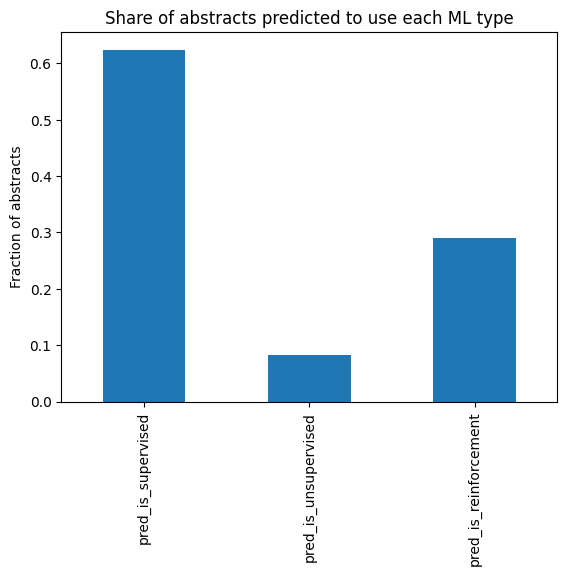

In [34]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

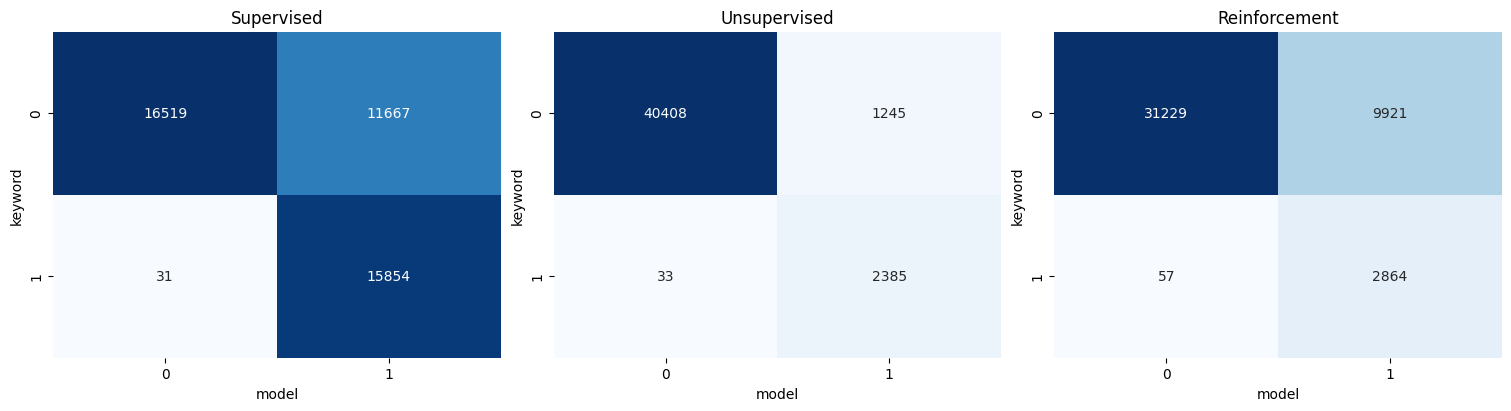

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [36]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 15854
FP: 11667
FN: 31
TN: 16519
Precision: 0.576
Recall:    0.998


=== is_unsupervised ===
TP: 2385
FP: 1245
FN: 33
TN: 40408
Precision: 0.657
Recall:    0.986


=== is_reinforcement ===
TP: 2864
FP: 9921
FN: 57
TN: 31229
Precision: 0.224
Recall:    0.980



In [37]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
40858,10.1109/APEC48143.2025.10977412,Dynamic Environment-Aware Lifetime Prediction ...,© 2025 IEEE.The state-of-the-art determines th...,0,0,1,1,0,1
23250,10.3390/electronics13030493,An Embedded Machine Learning Fault Detection S...,© 2024 by the authors.Industrial fans are crit...,0,0,1,1,0,1
10892,10.3390/app13031903,Machine Learning in Manufacturing towards Indu...,© 2023 by the authors.While attracting increas...,1,0,0,1,0,1
10260,NaN,Research on early identification of disruptive...,© 2023 Editorial Department of Studies in Scie...,0,0,1,1,0,1
38943,10.1016/j.petrol.2019.01.006,Optimization of models for a rapid identificat...,© 2019 Elsevier B.V.The identification of lith...,1,0,1,1,0,0
279,10.1109/CSIT65290.2024.10982564,Modern Methods of Data Preprocessing to Increa...,© 2024 IEEE.To minimize its idle time automate...,1,1,0,0,1,0
3989,10.1142/S0218194025500044,SPERT: Reinforcement Learning-Enhanced Transfo...,© 2025 World Scientific Publishing Company.Sto...,1,0,1,0,0,1
41433,10.1109/TIM.2023.3267362,Remaining Useful Life Prediction of Lithium-Io...,© 1963-2012 IEEE.Accurate prediction of the re...,1,0,0,1,1,0
41759,10.1109/ICSTCEE54422.2021.9708591,A hybrid approach estimates the real-time heal...,© 2021 IEEE.For Remaining useful life (RUL) pr...,1,0,1,1,1,1
11946,10.1109/JRFID.2023.3279329,SDN-Based Federated Learning Approach for Sate...,© 2017 IEEE.The proliferation of IoT devices a...,0,0,1,1,0,1


In [38]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       15950
pred_is_unsupervised      2448
pred_is_reinforcement     2901
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       11571
pred_is_unsupervised      1182
pred_is_reinforcement     9884
dtype: int64


In [39]:
# Rows not in training and predicted ONLY reinforcement learning
mask_only_rl_pred = (
    mask_not_train &
    (df["pred_is_reinforcement"] == 1) &
    (df["pred_is_supervised"] == 0) &
    (df["pred_is_unsupervised"] == 0)
)

df_only_rl_pred = df[mask_only_rl_pred]

print("Total non-trained rows predicted ONLY RL:", len(df_only_rl_pred), "\n")
df_only_rl_pred.head(10)


Total non-trained rows predicted ONLY RL: 9699 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,0,0,0,0,0,1
17,ml_anomaly_detection_production,2-s2.0-105008069752,10.1007/s10586-024-05001-5,Revolutionizing electric robot charging infras...,"© The Author(s), under exclusive licence to Sp...",", under exclusive licence to Springer Science+...",0,0,0,0,0,1
51,ml_anomaly_detection_production,2-s2.0-105003383541,10.3390/jmmp9040133,Recent Advances in In Situ 3D Surface Topograp...,© 2025 by the authors.Additive manufacturing (...,© 2025 by the authors.Additive manufacturing (...,0,0,0,0,0,1
53,ml_anomaly_detection_production,2-s2.0-105004559365,10.1515/zwf-2024-0154,Intelligent Process Monitoring for Flexible Ma...,"© 2025 Robin Ströbel, Hafez Kader, Louisa Hutt...","© 2025 Robin Ströbel, Hafez Kader, Louisa Hutt...",0,0,0,0,0,1
58,ml_anomaly_detection_production,2-s2.0-105000967139,10.3390/app15063337,AI-Driven Predictive Maintenance in Mining: A ...,© 2025 by the authors.The mining industry face...,© 2025 by the authors.The mining industry face...,0,0,0,0,0,1
74,ml_anomaly_detection_production,2-s2.0-85207869042,10.1007/978-981-97-7494-4_7,Deep Learning Approach Towards Green IIOT,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,0,0,1
92,ml_anomaly_detection_production,2-s2.0-105016316160,10.1109/ICOCT64433.2025.11118806,Automating Machine Learning Performance Monito...,© 2025 IEEE.The data analytics takes front row...,© 2025 IEEE.The data analytics takes front row...,0,0,0,0,0,1
117,ml_anomaly_detection_production,2-s2.0-105009408023,10.1016/j.procir.2025.03.046,Real-time process monitoring in additive manuf...,© 2025 Elsevier B.V.. All rights reserved.Addi...,© 2025 Elsevier B.V.. All rights reserved.Addi...,0,0,0,0,0,1
122,ml_anomaly_detection_production,2-s2.0-105008666081,10.1007/978-3-031-90203-1_1,LOMOS: An AI-Based Runtime Security Monitoring...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,0,0,1
129,ml_anomaly_detection_production,2-s2.0-105007338747,10.5121/ijcnc.2025.17308,AI-DRIVEN IOT-ENABLED UAV INSPECTION FRAMEWORK...,"© (2025), (Academy and Industry Research Colla...","© (2025), (Academy and Industry Research Colla...",0,0,0,0,0,1


In [40]:
# Number of predicted labels per row
pred_sum = df.loc[mask_not_train, pred_cols].sum(axis=1)

# Multilabeled = predicted 2 or 3 labels
n_multi = (pred_sum >= 2).sum()
n_total_not_train = mask_not_train.sum()

print("Total non-trained rows:", n_total_not_train)
print("Multilabeled predictions:", n_multi)
print("Share multilabeled:", round(n_multi / n_total_not_train, 3))

Total non-trained rows: 25000
Multilabeled predictions: 332
Share multilabeled: 0.013
